# MCI and Sampling-Importance Resampling (SIR)

#### Author: Bruno Cavani

---

Recall that from the Monte Carlo Integration (MCI, henceforth) one could use sampling procedure to well-estimate the value of integrals whose closed-form computation could be sufficiently cumbersome. However, it could actually be the case where we are not interested in calculating a particular moment of an unmanageable distribution, but to sample from this distribution. In many cases, our work guides us to densities whose distribution is not exactly identified (e.g. all those non-conjugated posterior distributions), and then sampling from its distribution can be onerous, even using powerful statistics softwares.

In these cases, in the same spirit of MCI, we could perform Sampling-Importance Resampling (SIR, henceforth) techniques to extract a sample of the an unmanageable $f$ distribution by taking a sample of a well-known $g$ distribution and transforming it in a intuitive manner.

Suppose one has samples from $g$, under the information that $f \approx g$, i.e.
\begin{align*}
    \{Y_k\}_{k=1}^N, \quad Y_k \sim g. \tag{Sampling}
\end{align*}
Hence, these samples from $g$ can be approximately-\textit{transformed} to samples from $f$ according to:

1. Define a vector of weights
\begin{align*}
    w_k = \frac{f(Y_k)}{g(Y_k)}
\end{align*}
where, after sampling from $g$, we can compute both the probabilities of drawing $Y_k$-value from each $f$ and $g$.

2. Standardize those weights in order to attend useful probability-properties
\begin{align*}
    \hat{w}_k = \frac{w_k}{\sum_{i=1}^N w_i}. \tag{Importance}
\end{align*}

3. For $k\in\{1,\ldots,N\}$, choose a new sample according to
\begin{align*}
    X_k = \begin{cases} Y_1, \ \text{ with probability } \hat{w}_1 \\ \ \vdots \\ Y_N, \ \text{ with probability } \hat{w}_N \end{cases} \tag{Resampling}
\end{align*}

### Example, Weighted-Resampling Algorithm (SIR)

Suppose one wants to simulate from
\begin{align*}
    \pi(\theta) \propto (2+\theta)^{125}(1-\theta)^{38}\theta^{34}
\end{align*}
for $\theta \in [0,1]$.

In [2]:
using Plots
using Distributions
using StatsBase
using PrettyTables

First, let us take a look on the shape of such probability distribution for such support of $\theta$, up to a normalizing constant.

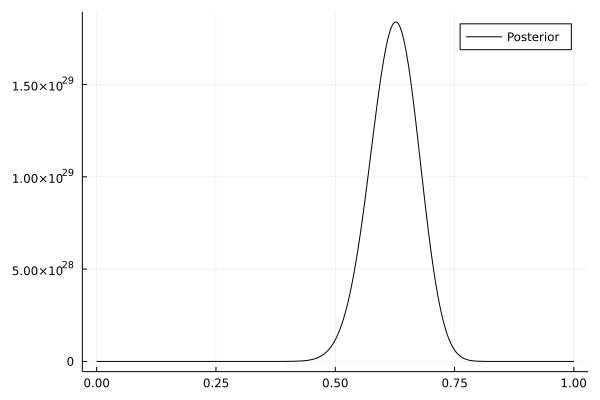

In [3]:
# Plotting posterior pi(theta) (up to a normalizing constant)

t = collect(0:.0001:1)
plot(t,(2*ones(length(t))+t).^(125).*(ones(length(t)).-t).^(38).*t.^(34),label="Posterior",c=:black)

Now, one may compute the normalizing constant (also known as the prior-predictive) using Monte Carlo integration. To do so, we can extract a sample of $\theta$-values from a known-distribution such as the Uniform(0,1), which plays the role of an importance function,

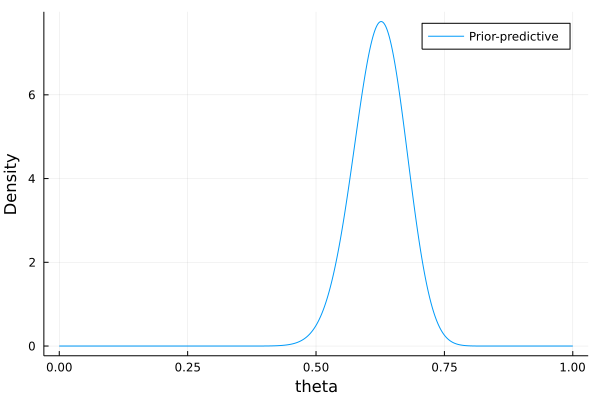

In [4]:
# Let's compute the normalizing constant (also known as prior predictive) via Monte Carlo integration

M = 100000
a = 0
b = 1
theta = rand(Uniform(a,b),M)
pred = mean((2*ones(length(theta)).+theta).^(125).*(ones(length(theta)).-theta).^(38).*theta.^(34))
post = (2*ones(length(t))+t).^(125).*(ones(length(t)).-t).^(38).*t.^(34)/pred
plot(t,post,ylabel="Density",xlabel="theta",label="Prior-predictive")

One could also compute the expected-value and the standard deviation of $\theta$, $\mathbb{E}[\theta]$, both using the same approach.

In [5]:
# computing E[theta]

I2 = pred
I1 = mean((2*ones(length(theta)).+theta).^(125).*(ones(length(theta)).-theta).^(38).*theta.^(35))
E  = I1/I2


# Computing Var(theta) = E[theta^2]-{E[theta]}^2
E2 = mean((2*ones(length(theta)).+theta).^(125).*(ones(length(theta)).-theta).^(38).*theta.^(36))/I2
E2


V = E2-E^2
SD = sqrt(V)

0.05077946586053595

On the other hand, in line with the main motivation of this study, we could actually want to draw from this posterior. The simplest solution to this problem is to adopt the SIR approach, i.e. (i) extract a sample of $M$-values of $\theta$ from an auxiliar function, $q(\cdot)$; (ii) compute and normalize the weights from the ratio of the auxiliar function by the original one; and (iii) resample $\theta$ from the weight-probability. The step-by-step procedure is carefully presented below.

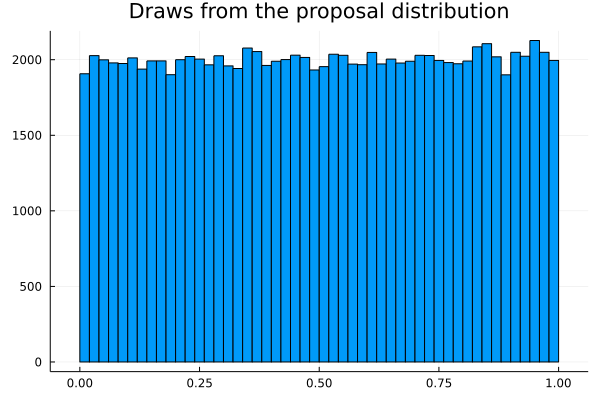

In [6]:
M = 100000

# SIR, Step 1: sampling from q(.) = Uniform(0,1)

theta = rand(Uniform(0,1),M)
histogram(theta,title="Draws from the proposal distribution",legend=false)


In [7]:
# SIR, Step 2: cumputing weights

numerator = (2*ones(length(theta)).+theta).^(125).*(ones(length(theta)).-theta).^(38).*theta.^(34)
denominator = 1
w = numerator/denominator
w = w/sum(w)

100000-element Vector{Float64}:
 3.3282836306252333e-16
 3.824515826689489e-9
 3.0674588087493395e-30
 1.2136406360375232e-17
 1.755237413494993e-8
 1.4334784248040935e-27
 7.163712975231393e-22
 1.0790480577726649e-10
 2.252881761254663e-28
 6.101827960061368e-5
 2.3720879395725526e-12
 6.027109336322886e-16
 1.4649104904155071e-16
 ⋮
 2.2316294634256465e-13
 7.318625425796112e-6
 2.860097358766548e-26
 1.7432493394999388e-6
 2.2064803381211153e-27
 6.193750877612951e-11
 2.4593790442146583e-30
 1.911816561146003e-42
 1.8611795956192296e-8
 2.189386988913271e-8
 2.0578004272832135e-6
 6.807342602854988e-5

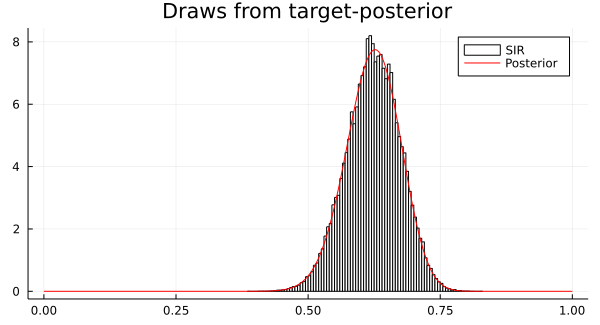

In [22]:
# SIR, Step 3: resampling the set of thetas with the weights

theta1 = sample(theta, Weights(w),M,replace=true)
histogram(theta1,title="Draws from target-posterior",normalize=true,c=:white,label="SIR",size=(600,325))
plot!(t,post,c=:red,label="Posterior")

Finally, one could be motivated to compare the results from the MC integration with the SIR.

In [20]:
# Comparing MC integration with SIR

MCI = round.([E,V,SD],digits=6)
SIR = round.([mean(theta1),var(theta1),std(theta1)],digits=6)
data = hcat(["Mean","Variance","Standard Deviation"],MCI,SIR)
pretty_table(data,header=["","MCI","SIR"],header_crayon=crayon"blue bold")

┌────────────────────┬──────────┬──────────┐
│                    │      MCI │      SIR │
├────────────────────┼──────────┼──────────┤
│               Mean │ 0.622793 │ 0.622786 │
│           Variance │ 0.002579 │ 0.002612 │
│ Standard Deviation │ 0.050779 │ 0.051111 │
└────────────────────┴──────────┴──────────┘
